# Integrate MLP and CNN.

In [517]:
# Import Statements
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # Functipn to split data into training, validation and test sets
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import glob   # The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order. No tilde expansion is done, but *, ?, and character ranges expressed with [] will be correctly matched.
import os   # miscellneous operating system interfaces. This module provides a portable way of using operating system dependent functionality. If you just want to read or write a file see open(), if you want to manipulate paths, see the os.path module, and if you want to read all the lines in all the files on the command line see the fileinput module.
import random       
from tqdm import tqdm 
from tqdm.notebook import tqdm_notebook
import datetime
import time
from tabulate import tabulate

# Torch
import torch
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import torchinfo


# Image analysis packages
import albumentations as A 
import cv2          

In [518]:
# In[2]:
start = time.time()
now = datetime.datetime.now()
now = now.strftime("%d_%m_%Y-%H:%M:%S")

# get the dictionary for compound_id-SMILES pair 
compound_smiles_dictionary = pickle.load(open("/home/jovyan/Tomics-CP-Chem-MoA/data_for_models/dictionary2.pickle", "rb"))

In [519]:
# 10 selected MoAs 
moas_to_use = ['Aurora kinase inhibitor', 'tubulin polymerization inhibitor', 'JAK inhibitor', 'protein synthesis inhibitor', 'HDAC inhibitor', 
        'topoisomerase inhibitor', 'PARP inhibitor', 'ATPase inhibitor', 'retinoid receptor agonist', 'HSP inhibitor']


# read the data 
all_data = pd.read_csv('/home/jovyan/Tomics-CP-Chem-MoA/data_for_models/all_data.csv')


# In[6]:


# Limiting the data to the first 2000 rows
testing = True
if testing == True:
    all_data = all_data[0:1000]


# In[7]:


# drop random previous index in table above
all_data.drop(all_data.columns[[0,11, 12]], axis=1, inplace=True) # Check that reading the data worked 


# In[8]:


dictionary = {'ATPase inhibitor': 7, 'Aurora kinase inhibitor': 0,
 'HDAC inhibitor': 4, 'HSP inhibitor': 9, 'JAK inhibitor': 2, 'PARP inhibitor': 6,
 'protein synthesis inhibitor': 3, 'retinoid receptor agonist': 8,
 'topoisomerase inhibitor': 5, 'tubulin polymerization inhibitor': 1}


# In[9]:


num_classes = len(dictionary) 
#num_classes


# In[10]:


# change moa to classes 
all_data['classes'] = None
for i in range(all_data.shape[0]):
    all_data.iloc[i, 10] = dictionary[all_data.iloc[i, 9]]


# In[11]:


# get the compound-MoA pair 
compound_moa = all_data[['compound','moa']].drop_duplicates()


# In[12]:


# creating tensor from all_data.df
target = torch.tensor(all_data['classes'].values.astype(np.int64))
target, target.shape


# In[13]:

# For each row, take the index of the tar- get label
# (which coincides with the score in our case) and use it as the column index to set the value 1.0.” 
target_onehot = torch.zeros(target.shape[0], num_classes)
target_onehot.scatter_(1, target.unsqueeze(1), 1.0)


# In[14]:

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

In [520]:
# split dataset into test and training/validation sets (10-90 split)
compound_CP_train_valid, compound_CP_test, compound_CP_moa_train_valid, compound_CP_moa_test = train_test_split(
  compound_moa.compound, compound_moa.moa, test_size = 0.10, stratify = compound_moa.moa, 
  shuffle = True, random_state = 1)


# Split data set into training and validation sets (1 to 9)
# Same as above, but does split of only training data into training and validation data (in order to take advantage of stratification parameter)
compound_CP_train, compound_CP_valid, compound_CP_moa_train, compound_CP_moa_valid = train_test_split(
  compound_CP_train_valid, compound_CP_moa_train_valid, test_size = 10/90, stratify = compound_CP_moa_train_valid,
  shuffle = True, random_state = 62757)

In [521]:
compound_CP_train.dtypes


dtype('O')

In [522]:
# get the train, valid and test set by for every compound in data set, if it is in train, valid or test, return all info from all_data in new df.
train = all_data[all_data['compound'].isin(compound_CP_train)]
valid = all_data[all_data['compound'].isin(compound_CP_valid)]
test  = all_data[all_data['compound'].isin(compound_CP_test)]
''' Explanation
reset_index = create new index starting from zero 
drop: drop previous index.
'''

' Explanation\nreset_index = create new index starting from zero \ndrop: drop previous index.\n'

In [523]:
train[train.compound.isin(valid.compound.unique())]

,plate,well,compound,path,C1,C2,C3,C4,C5,moa,classes


In [524]:
test[test.compound.isin(valid.compound.unique())]

,plate,well,compound,path,C1,C2,C3,C4,C5,moa,classes


In [525]:
train[train.compound.isin(test.compound.unique())]

,plate,well,compound,path,C1,C2,C3,C4,C5,moa,classes


In [526]:
# create dictionary for parition
partition = {"train": [], "valid": [], "test": []}

# create lists with indexes in splits
tr_list = train.index.tolist()
va_list = valid.index.tolist()

# place index into correct bin
for index in all_data.index.tolist():
#for index in compound_moa.index.tolist():
    if index in tr_list:
        partition["train"] += [index]
    elif index in va_list:
        partition["valid"]   += [index]
    else:
        partition["test"]  += [index]

In [527]:
a = partition["train"]
b = partition["valid"]
c = [i for i in a if i in b]
c

[]

In [528]:
#CBK308980

In [529]:
# create dictionary for labels, using PyTorch
labels = {}
for index,compound in zip(all_data.index.tolist(), target_onehot):
    labels[index] = compound


batch_size = 20
# parameters
params = {'batch_size' : 20,
         'num_workers' : 3,
         'shuffle' : True,
         'prefetch_factor' : 1} 
          
# shuffle isn't working

# maxepochs
max_epochs = 10


# In[74]:


device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
#device = torch.device('cpu')
print(f'Training on device {device}. ' )


# In[75]:
import albumentations as A
train_transforms = A.Compose([A.Flip(),A.ShiftScaleRotate(scale_limit=0.2),A.RandomRotate90(),
    A.OneOf([A.Flip(),A.ShiftScaleRotate(scale_limit=0.2),A.RandomRotate90(),],p = 0.2),
    A.OneOf([A.Flip(),A.ShiftScaleRotate(scale_limit=0.2),A.RandomRotate90(),],p = 0.4),
    A.OneOf([A.Flip(),A.ShiftScaleRotate(scale_limit=0.2),A.RandomRotate90(),],p = 0.5),
    A.OneOf([A.Flip(),A.ShiftScaleRotate(scale_limit=0.2),A.RandomRotate90(),],p = 0.6),
    A.OneOf([A.Flip(),A.ShiftScaleRotate(scale_limit=0.2),A.RandomRotate90(),],p = 0.8),
    A.Flip(),A.ShiftScaleRotate(scale_limit=0.2),A.RandomRotate90(),])
valid_transforms = A.Compose([])

def channel_5_numpy(df, idx):
    '''
    Puts together all channels from CP imaging into a single 5 x 256 x 256 tensor (c x h x w) from all_data.csv
    Input
    df  : file which contains all rows of image data with compound information (type = csv)
    idx : the index of the row (type = integer)
    
    Output:
    image: a single 5 x 256 x 256 tensor (c x h x w)
    '''
    # extract row with index 
    row = df.iloc[idx]
    
    # loop through all of the channels and add to single array
    im = []
    for c in range(1, 6):
        # extract by adding C to the integer we are looping
        row_channel_path = row["C" + str(c)]
        local_im = cv2.imread(row.path + "/" + row["C" + str(c)], -1) # row.path would be same for me, except str(row[path]))
        
        # directly resize down to 256 by 256
        local_im = cv2.resize(local_im, (256, 256), interpolation = cv2.INTER_LINEAR)
        # adds to array to the image vector 
        im.append(local_im)

    # once we have all the channels, we covert it to a np.array, transpose so it has the correct dimensions and change the type for some reason
    im = np.array(im).astype("int16")
    return torch.from_numpy(im)

# A function changing SMILES to Morgan fingerprints 
def smiles_to_array(smiles):
    molecules = Chem.MolFromSmiles(smiles) 
    fingerprints = AllChem.GetMorganFingerprintAsBitVect(molecules, 2)
    x_array = []
    arrays = np.zeros(0,)
    DataStructs.ConvertToNumpyArray(fingerprints, arrays)
    x_array.append(arrays)
    x_array = np.asarray(x_array)
    x_array = ((np.squeeze(x_array)).astype(int)) 
    x_array = torch.from_numpy(x_array)
    return x_array                  


# create Torch.dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, partition, labels, transform= None):
        self.compound_labels = labels    # the entire length of the correct classes that we are trying to predict
        # print(self.img_labels)
        self.list_ID = partition         # list of indexes that are a part of training, validation, tes sets
        self.transform = transform       # any transformations done

    def __len__(self):
        ''' The number of data points '''
        return len(self.compound_labels)      

    def __getitem__(self, idx):
        '''Retrieving the compound '''
        #print(idx)                                    # check to see if idx is monotonically growing starting from zero
        #ID = self.list_ID[idx]                        # we extract an index in partition representing training/valid/test set
        #print(ID)
        ID = idx
        nrow = all_data.iloc[ID]    # extract row from csv using index
        b = nrow["compound"]
        #print(f' {b}')
        #b= nrow["compound"]
        #print(f' nrow {b}')
        #a = compound_moa.index[compound_moa['compound']== nrow["compound"]]
        #a = a[0]
        #print(f' finding it in moa = {a}')
        #print(f' commpound {nrow["compound"]}')
        #print(f' the compound ive extracted: {compound_moa.iloc[a]}')
        #compound = compound_smiles_dictionary[compound_moa.iloc[a]]
        compound = compound_smiles_dictionary[nrow["compound"]]      # returns smiles by using compound as key
        compound_array = smiles_to_array(compound)
        image = channel_5_numpy(all_data, ID)
        #print(f' return from function: {compound}')
        #print(f' matrix: {compound_array}')
        label = self.compound_labels[ID]             # extract classification using index
        #print(f' label: {label}')
        #label = torch.tensor(label, dtype=torch.float)
        if self.transform:                         # uses Albumentations image pipeline to return an augmented image
            image = self.transform(image)
        #return image.float(), label.long()

        #print(f' Compound {compound_array.float()}')
        #print(f' Image {image.float()}')
        #print(f' Label {label.float()}')
        return compound_array.float(), image.float(), label.float()

Training on device cuda. 


In [530]:
# Create a dataset with all indices and labels
everything = Dataset(partition["train"]+partition['valid']+partition['test'], labels)



# generator: training
# create a subset with only train indices
training_set = torch.utils.data.Subset(everything, partition["train"])

# create generator that randomly takes indices from the training set
training_generator = torch.utils.data.DataLoader(training_set, **params)
# training_set = Dataset(partition["train"], labels)


# In[83]:

In [531]:
# training data loader
# Display image and label   # functional
train_compounds, train_imgs, train_labels = next(iter(training_generator))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")

In [532]:
partition['train'][0:20]

[0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 24, 25]

In [533]:
hello = compound_CP_train.tolist()
bro = compound_CP_valid.tolist()
cnn = compound_CP_test.tolist()
print(cnn)
#for i in  ['CBK290493', 'CBK290052', 'CBK288284', 'CBK277990', 'CBK290683','CBK201011','CBK303971','CBK293875','CBK200860','CBK290573','CBK309538','CBK308097','CBK278067','CBK200551','CBK309084']:
#for i in  ['CBK288327','CBK308232','CBK288302','CBK277950','CBK291055','CBK289731','CBK308631','CBK277968','CBK308108','CBK290573','CBK201016','CBK308819','CBK277973','CBK290217','CBK041779']:
for i in ['CBK290770',
 'CBK309655',
 'CBK309040',
 'CBK200898',
 'CBK309538',
 'CBK309020',
 'CBK293875',
 'CBK291084',
 'CBK309255',
 'CBK308864',
 'CBK041804',
 'CBK200551',
 'CBK290766',
 'CBK309084',
 'CBK011613',
 'CBK200860',
 'CBK289987',
 'CBK307798',
 'CBK041242',
 'CBK288285']:
    if i in hello:
        print("in train")
        
    elif i in bro:
        print(i)
        print("in valid")
    else:
        print(i)
        print("in test")


['CBK290655', 'CBK288286', 'CBK277950', 'CBK308484', 'CBK200838', 'CBK308980', 'CBK290684', 'CBK308359', 'CBK290287', 'CBK041487', 'CBK277934', 'CBK290848', 'CBK303867', 'CBK291055', 'CBK041720', 'CBK277909', 'CBK307816', 'CBK290588', 'CBK277961', 'CBK290717', 'CBK309522', 'CBK278016', 'CBK201093']
in train
in train
in train
in train
in train
in train
in train
in train
in train
in train
in train
in train
in train
in train
in train
in train
in train
in train
in train
in train


In [534]:
# training data loader
# Display image and label   # functional
#train_features, train_labels = next(iter(training_generator))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")


# In[84]:


# Validation Set
# create a subset with only valid indices
valid_set = torch.utils.data.Subset(everything, partition["valid"])
    
# create generator that randomly takes indices from the validation set
valid_generator = torch.utils.data.DataLoader(valid_set, **params)
valid_compounds, valid_imgs, valid_labels = next(iter(valid_generator))

In [535]:
partition['valid'][0:20]

[8,
 14,
 33,
 45,
 46,
 49,
 57,
 78,
 81,
 84,
 86,
 114,
 120,
 124,
 141,
 145,
 159,
 167,
 186,
 193]

In [536]:
# Test set
# create a subset with only test indices
test_set = torch.utils.data.Subset(everything, partition["test"])

# create generator that randomly takes indices from the test set
test_generator = torch.utils.data.DataLoader(test_set, **params)# generator for validation data

In [537]:
# If applying class weights
apply_class_weights = True
if apply_class_weights:     # if we want to apply class weights
    counts = compound_moa.moa.value_counts()  # count the number of moa in each class for the ENTiRE dataset
    #print(counts)
    class_weights = []   # create list that will hold class weights
    for moa in compound_moa.moa.unique():       # for each moa   
        #print(moa)
        counts[moa]
        class_weights.append(counts[moa])  # add counts to class weights
    #print(len(class_weights))
    #print(class_weights)
    #print(type(class_weights))
    # class_weights = 1 / (class_weights / sum(class_weights)) # divide all class weights by total moas
    class_weights = [i / sum(class_weights) for  i in class_weights]
    class_weights= torch.tensor(class_weights,dtype=torch.float).to(device) # transform into tensor, put onto device
#print(class_weights)

In [538]:
# training data loader
# Display image and label   # functional
train_compounds, train_imgs, train_labels = next(iter(training_generator))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")

In [539]:
def training_loop(n_epochs, model, loss_fn, train_loader, valid_loader):
    '''
    n_epochs: number of epochs 
    optimizer: optimizer used to do backpropagation
    model: deep learning architecture
    loss_fn: loss function
    train_loader: generator creating batches of training data
    valid_loader: generator creating batches of validation data
    '''
    # lists keep track of loss and accuracy for training and validation set
    model = model.to(device=device)
    optimizer = torch.optim.Adam(model.parameters(),weight_decay = 1e-6, lr = 0.001, betas = (0.9, 0.999), eps = 1e-07)
    train_loss_per_epoch = []
    train_acc_per_epoch = []
    val_loss_per_epoch = []
    val_acc_per_epoch = []
    best_val_loss = np.inf
    for epoch in tqdm(range(1, max_epochs +1), desc = "Epoch", position=0, leave= True):
        loss_train = 0.0
        train_total = 0
        train_correct = 0
        for compounds, imgs, labels in train_loader:
            optimizer.zero_grad()
            # put model, images, labels on the same device
            compounds = compounds.to(device = device)
            imgs = imgs.to(device = device)
            labels = labels.to(device= device)
            # Training Model
            outputs = model(compounds, imgs)
            #print(f' Outputs : {outputs}') # tensor with 10 elements
            #print(f' Labels : {labels}') # tensor that is a number
            loss = loss_fn(outputs,labels)
            # For L2 regularization
            l2_lambda = 0.000001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            # Update weights
            loss.backward()
            optimizer.step()
            # Training Metrics
            loss_train += loss.item()
            #print(f' loss: {loss.item()}')
            train_predicted = torch.argmax(outputs, 1)
            #print(f' train_predicted {train_predicted}')
            # NEW
            labels = torch.argmax(labels,1)
            #print(labels)
            train_total += labels.shape[0]
            train_correct += int((train_predicted == labels).sum())
        # validation metrics from batch
        val_correct, val_total, val_loss, best_val_loss_upd = validation_loop(model, loss_fn, valid_loader, best_val_loss)
        best_val_loss = best_val_loss_upd
        val_accuracy = val_correct/val_total
        # printing results for epoch
        if epoch == 1 or epoch %5 == 0:
            print(f' {datetime.datetime.now()} Epoch: {epoch}, Training loss: {loss_train/len(train_loader)}, Validation Loss: {val_loss} ')
        # adding epoch loss, accuracy to lists 
        val_loss_per_epoch.append(val_loss)
        train_loss_per_epoch.append(loss_train/len(train_loader))
        val_acc_per_epoch.append(val_accuracy)
        train_acc_per_epoch.append(train_correct/train_total)
    # return lists with loss, accuracy every epoch
    return train_loss_per_epoch, train_acc_per_epoch, val_loss_per_epoch, val_acc_per_epoch
                                

# In[64]:

def validation_loop(model, loss_fn, valid_loader, best_val_loss):
    '''
    Assessing trained model on valiidation dataset 
    model: deep learning architecture getting updated by model
    loss_fn: loss function
    valid_loader: generator creating batches of validation data
    '''
    model = model.to(device)
    model.eval()
    loss_val = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  # does not keep track of gradients so as to not train on validation data.
        for compounds, imgs, labels in valid_loader:
            # Move to device MAY NOT BE NECESSARY
            compounds = compounds.to(device=device)
            imgs = imgs.to(device = device)
            labels = labels.to(device= device)
            # Assessing outputs
            outputs = model(compounds, imgs)
            #print(f' Outputs : {outputs}') # tensor with 10 elements
            #print(f' Labels : {labels}') # tensor that is a number
            loss = loss_fn(outputs,labels)
            loss_val += loss.item()
            predicted = torch.argmax(outputs, 1)
            labels = torch.argmax(labels,1)
            #print(predicted)
            #print(labels)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
        avg_val_loss = loss_val/len(valid_loader)  # average loss over batch
        if best_val_loss > loss_val:
            best_val_loss = loss_val
            torch.save(
                {
                    'model_state_dict' : model.state_dict(),
                    'valid_loss' : loss_val
            },  '/home/jovyan/Tomics-CP-Chem-MoA/03_Global_CStructure_CP_Models/saved_models' +'/' + 'CS_CP_least_loss_model'
            )
    model.train()
    return correct, total, avg_val_loss, best_val_loss

def results_assessment(y_true, y_pred):
    save_path = '/home/jovyan/Tomics-CP-Chem-MoA/03_Global_CStructure_CP_Models/'
    target_names = ['Aurora kinase inhibitor', 'tubulin polymerization inhibitor',
     'JAK inhibitor', 'protein synthesis inhibitor', 'HDAC inhibitor', 'topoisomerase inhibitor', 
     'PARP inhibitor','ATPase inhibitor', 'retinoid receptor agonist', 'HSP inhibitor']
    #print(f' true {y_true}')
    #print(f' prediction {y_pred}')
    for count, ele in enumerate(target_names):
        #print(count)
        #print(ele)
        #print(dictionary[ele])
        assert count == dictionary[ele], "Mismatch with dictionary"
    
    class_report_output = classification_report(y_true, y_pred)
    try:
        chem_struc_file= open(save_path + 'saved_classification_reports' + '/' + now + '_classif_report.txt', 'a')
        chem_struc_file.write((class_report_output))
        chem_struc_file.close()
    except:
        print("Unable to append to file")
    
    conf_matrix = confusion_matrix(y_true, y_pred)
    np.save((save_path + 'saved_confusion_matrices/'  + now + '_confusion_matrix.npy'), conf_matrix)



def test_loop(model, loss_fn, test_loader):
    '''
    Assessing trained model on test dataset 
    model: deep learning architecture getting updated by model
    loss_fn: loss function
    test_loader: generator creating batches of test data
    '''
    model = model.to(device)
    model.eval()
    loss_test = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():  # does not keep track of gradients so as to not train on test data.
        for compounds, imgs, labels in tqdm(test_loader,
                                            desc = "Test Batches w/in Epoch",
                                              position = 0,
                                              leave = True):
            # Move to device MAY NOT BE NECESSARY
            imgs = imgs.to(device = device)
            compounds = compounds.to(device = device)
            labels = labels.to(device= device)
            # Assessing outputs
            outputs = model(compounds, imgs)
            # print(f' Outputs : {outputs}') # tensor with 10 elements
            # print(f' Labels : {labels}') # tensor that is a number
            loss = loss_fn(outputs,labels)
            loss_test += loss.item()
            predicted = torch.argmax(outputs, 1)
            labels = torch.argmax(labels,1)
            #print(predicted)
            #print(labels)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
            #print(f' Predicted: {predicted.tolist()}')
            #print(f' Labels: {predicted.tolist()}')
            all_predictions = all_predictions + predicted.tolist()
            all_labels = all_labels + labels.tolist()
        results_assessment(all_predictions, all_labels)
        avg_test_loss = loss_test/len(test_loader)  # average loss over batch
    return correct, total, avg_test_loss



# In[69]:


def val_vs_train_loss(epochs, train_loss, val_loss):
    ''' 
    Plotting validation versus training loss over time
    epochs: number of epochs that the model ran (int. hyperparameter)
    train_loss: training loss per epoch (python list)
    val_loss: validation loss per epoch (python list)
    ''' 
    loss_path_to_save = '/home/jovyan/Tomics-CP-Chem-MoA/03_Global_CStructure_CP_Models/saved_images'
    plt.figure()
    x_axis = list(range(1, epochs +1)) # create x axis with number of
    plt.plot(x_axis, train_loss, label = "train_loss")
    plt.plot(x_axis, val_loss, label = "val_loss")
    # Figure description
    plt.xlabel('# of Epochs')
    plt.ylabel('Loss')
    plt.title('Validation versus Training Loss: CP Image Model')
    plt.legend()
    # plot
    plt.show()
    plt.savefig(loss_path_to_save + '/' + 'loss_train_val'+ now)



# In[70]:


def val_vs_train_accuracy(epochs, train_acc, val_acc):
    '''
    Plotting validation versus training loss over time
    epochs: number of epochs that the model ran (int. hyperparameter)
    train_acc: accuracy loss per epoch (python list)
    val_acc: accuracy loss per epoch (python list)
    '''
    acc_path_to_save = '/home/jovyan/Tomics-CP-Chem-MoA/03_Global_CStructure_CP_Models/saved_images'
    plt.figure()
    x_axis = list(range(1, epochs +1)) # create x axis with number of
    plt.plot(x_axis, train_acc, label = "train_acc")
    plt.plot(x_axis, val_acc, label = "val_acc")
    # Figure description
    plt.xlabel('# of Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation versus Training Accuracy: CP Image Model')
    plt.legend()
    # plot
    plt.savefig(acc_path_to_save + '/' + 'acc_train_val' + now)


# In[71]:




In [540]:
# loss_function
if apply_class_weights == True:
    loss_function = torch.nn.CrossEntropyLoss(class_weights)
else:
    loss_function = torch.nn.CrossEntropyLoss()


In [554]:
def set_parameter_requires_grad(model, feature_extracting):
    '''
    Turns off tracking of gradients
    '''
    
    if feature_extracting:
        print("feature extracting in progress")
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("fine_tuning in progress")
        for param in model.parameters():
            param.requires_grad = True

In [542]:
from efficientnet_pytorch import EfficientNet             # have to download it, since latest version can use torchvision.models
#base_model = EfficientNet.from_name('efficientnet-b1', include_top=False, in_channels = 5)

class image_network(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = EfficientNet.from_name('efficientnet-b1', include_top=False, in_channels = 5)
        self.dropout_1 = nn.Dropout(p = 0.3)
        self.Linear_last = nn.Linear(1280, 10)
        #self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, x):
        out = self.dropout_1(self.base_model(x))
        out = out.view(-1, 1280)
        out = self.Linear_last(out)
        # out = self.softmax(out) # don't need softmax when using CrossEntropyLoss
        return out

In [543]:
seq_model = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Dropout(p = 0.3),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64, 10))

In [544]:
# create a model combining both models
class CStructure_CP(nn.Module):
    def __init__(self, modelCS, modelCP):
        super(CStructure_CP, self).__init__()
        self.modelCS = modelCS
        self.modelCP = modelCP
        self.linear_layer1 = nn.Linear(int(1280 + 64), 128)
        self.selu = nn.SELU()
        self.Dropout = nn.Dropout(p = 0.5)
        self.linear_layer2 = nn.Linear(128,10)
       
    def forward(self, x1, x2):
        #print(f' compound: {x1.size()}')
        #print(f' image: {x2.size()}')
        x1 = self.modelCS(x1)
        x2 = self.modelCP(x2)
        x  = torch.cat((x1, x2), dim = 1)
        x = self.Dropout(self.selu(self.linear_layer1(x)))
        output = self.linear_layer2(x)
        return output

## Feature Extraction

In [545]:
model_extraction = True

In [546]:
#modelCP= torch.load('/home/jovyan/Tomics-CP-Chem-MoA/02_CP_Models/saved_models/CP_least_loss_model')
#modelCP.parameters()

In [555]:
# Create Model for Cell Painting
modelCP = image_network()
checkpoint = torch.load('/home/jovyan/Tomics-CP-Chem-MoA/02_CP_Models/saved_models/CP_least_loss_model') # gives dictionary
#try: 
#    checkpoint.eval()
#except AttributeError as error:
#    print("error")

### 'dict' object has no attribute 'eval'
modelCP.load_state_dict(checkpoint["model_state_dict"])
set_parameter_requires_grad(modelCP, model_extraction)
modelCP.Linear_last = nn.Identity()
# modelCP.to(device)
#torchinfo.summary(modelCP, (4, 5, 256,256), col_names=["kernel_size", "output_size", "num_params"])

fine_tuning in progress


In [556]:
modelCS = seq_model
checkpoint = torch.load('/home/jovyan/Tomics-CP-Chem-MoA/01_CStructure_Models/saved_models/ChemStruc_Least_Loss_Model')
modelCS.load_state_dict(checkpoint["model_state_dict"])
modelCS = nn.Sequential(*[modelCS[i] for i in range(4)])
modelCS.to(device)
#torchinfo.summary(modelCS, (4, 2048), col_names=["kernel_size", "output_size", "num_params"])
#set_parameter_requires_grad(modelCP, model_extraction)

Sequential(
  (0): Linear(in_features=2048, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
)

In [549]:
checkpoint["time_create"]

'20_12_2022-10:57:57'

In [550]:
# Load state_dicts
CS_CP_jointmodel = CStructure_CP(modelCS, modelCP)


In [551]:
train_loss_per_epoch, train_acc_per_epoch, val_loss_per_epoch, val_acc_per_epoch = training_loop(n_epochs = max_epochs,
              #optimizer = optimizer,
              model = CS_CP_jointmodel,
              loss_fn = loss_function,
              train_loader=training_generator, 
              valid_loader=valid_generator)


Epoch:  10%|█         | 1/10 [00:13<01:59, 13.23s/it]

 2022-12-21 09:20:35.844402 Epoch: 1, Training loss: 0.07788850422948598, Validation Loss: 0.017501999003191788 


Epoch:  50%|█████     | 5/10 [01:08<01:08, 13.70s/it]

 2022-12-21 09:21:30.685152 Epoch: 5, Training loss: 0.008808909030631185, Validation Loss: 0.0061861144786234945 


Epoch: 100%|██████████| 10/10 [02:16<00:00, 13.68s/it]

 2022-12-21 09:22:39.381294 Epoch: 10, Training loss: 0.008364439848810435, Validation Loss: 0.004806690888168911 


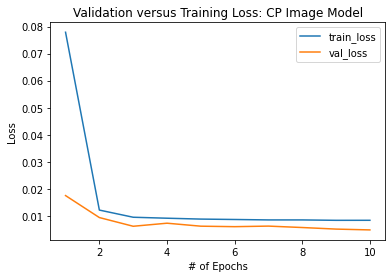

Test Batches w/in Epoch: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

╒══════════════════════╤════════════╕
│ Time to Run Program  │ 2.8985 min │
├──────────────────────┼────────────┤
│ Accuracy of Test Set │ 80.61 %    │
╘══════════════════════╧════════════╛


<Figure size 432x288 with 0 Axes>

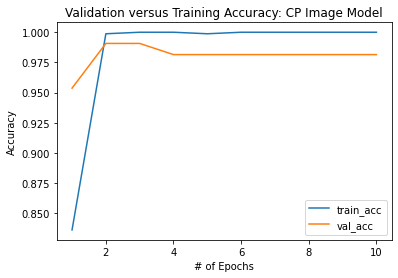

In [552]:
val_vs_train_loss(max_epochs,train_loss_per_epoch, val_loss_per_epoch)


# In[72]:


val_vs_train_accuracy(max_epochs, train_acc_per_epoch, val_acc_per_epoch)

correct, total, avg_test_loss = test_loop(model = CS_CP_jointmodel,
                                          loss_fn = loss_function, 
                                          test_loader = test_generator)

end = time.time()
def program_elapsed_time(start, end):
    program_time = round(end - start, 2) 
    #print(program_time)
    if program_time > float(60) and program_time < 60*60:
        program_time =  program_time/60
        time_elapsed = str(program_time) + ' min'
    elif program_time > 60*60:
        program_time = program_time/3600
        time_elapsed = str(program_time) + ' hrs'
    else:
        time_elapsed = str(program_time) + ' sec'
    return time_elapsed
program_elapsed_time = program_elapsed_time(start, end)

test_set_acc = f' {round(correct/total*100, 2)} %'
table = [["Time to Run Program", program_elapsed_time],
['Accuracy of Test Set', test_set_acc]]
print(tabulate(table, tablefmt='fancy_grid'))


## Fintuning

In [553]:
model_extraction = False
set_parameter_requires_grad(modelCS, model_extraction)
set_parameter_requires_grad(modelCP, model_extraction)
max_epochs = 2


feature extracting in progress
feature extracting in progress


In [506]:
train_loss_per_epoch, train_acc_per_epoch, val_loss_per_epoch, val_acc_per_epoch = training_loop(n_epochs = max_epochs,
              #optimizer = optimizer,
              model = CS_CP_jointmodel,
              loss_fn = loss_function,
              train_loader=training_generator, 
              valid_loader=valid_generator)


Epoch:  50%|█████     | 1/2 [00:16<00:16, 16.05s/it]

 2022-12-21 09:12:29.340099 Epoch: 1, Training loss: 0.005884548090398312, Validation Loss: 0.08305453571180503 


Epoch: 100%|██████████| 2/2 [00:30<00:00, 15.33s/it]


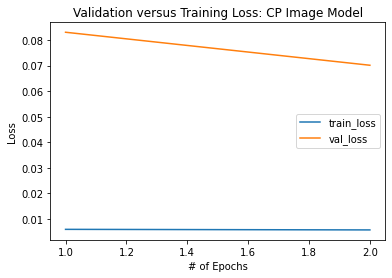

Test Batches w/in Epoch: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

1296.28
╒══════════════════════╤════════════════════════╕
│ Time to Run Program  │ 21.604666666666667 min │
├──────────────────────┼────────────────────────┤
│ Accuracy of Test Set │ 61.22 %                │
╘══════════════════════╧════════════════════════╛



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

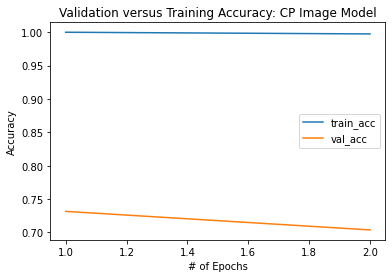

In [507]:
val_vs_train_loss(max_epochs,train_loss_per_epoch, val_loss_per_epoch)


# In[72]:


val_vs_train_accuracy(max_epochs, train_acc_per_epoch, val_acc_per_epoch)

correct, total, avg_test_loss = test_loop(model = CS_CP_jointmodel,
                                          loss_fn = loss_function, 
                                          test_loader = test_generator)

end = time.time()
def program_elapsed_time(start, end):
    program_time = round(end - start, 2) 
    print(program_time)
    if program_time > float(60) and program_time < 60*60:
        program_time =  program_time/60
        time_elapsed = str(program_time) + ' min'
    elif program_time > 60*60:
        program_time = program_time/3600
        time_elapsed = str(program_time) + ' hrs'
    else:
        time_elapsed = str(program_time) + ' sec'
    return time_elapsed
program_elapsed_time = program_elapsed_time(start, end)

test_set_acc = f' {round(correct/total*100, 2)} %'
table = [["Time to Run Program", program_elapsed_time],
['Accuracy of Test Set', test_set_acc]]
print(tabulate(table, tablefmt='fancy_grid'))